# QA RAG Chains with LCEL in LangChain
* Notebook by Adam Lang
* Date: 8/23/2024

# Overview
* We will go over how to build a QA RAG chain in LCEL in LangChain.


# RAG Workflow Step 1 - Data Processing and Indexing

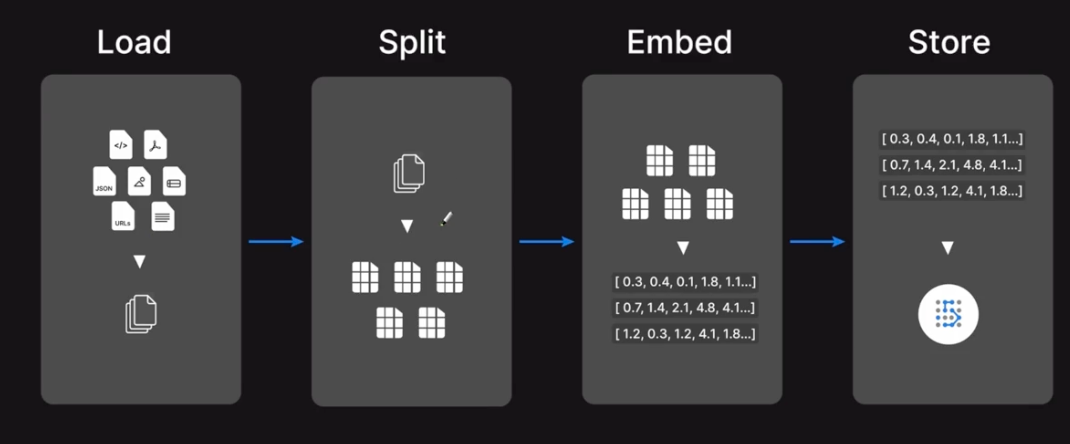

Step 1 is:
1. Load documents
2. Split and chunk data
3. Embeddings creation
4. Store embeddings in Vector database

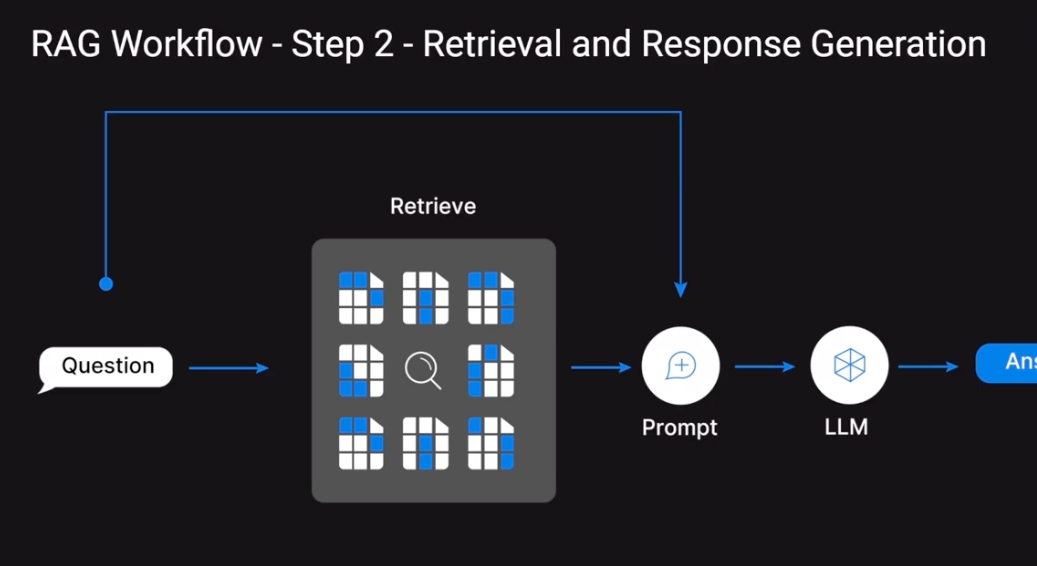

Step 2
1. Prompt sent to Vector DB.
2. Retrieval from Vector DB based on similarity metric.
3. Sent to LLM
4. Answer generated

## QA RAG Chain in LCEL
* LangChain Pipeline
1. user input sent to `RunnablePassthrough` to `QA_prompt`.
2. user input also sent to `retriever` to `format_docs`
3. Both fed to qa prompt to LLM.

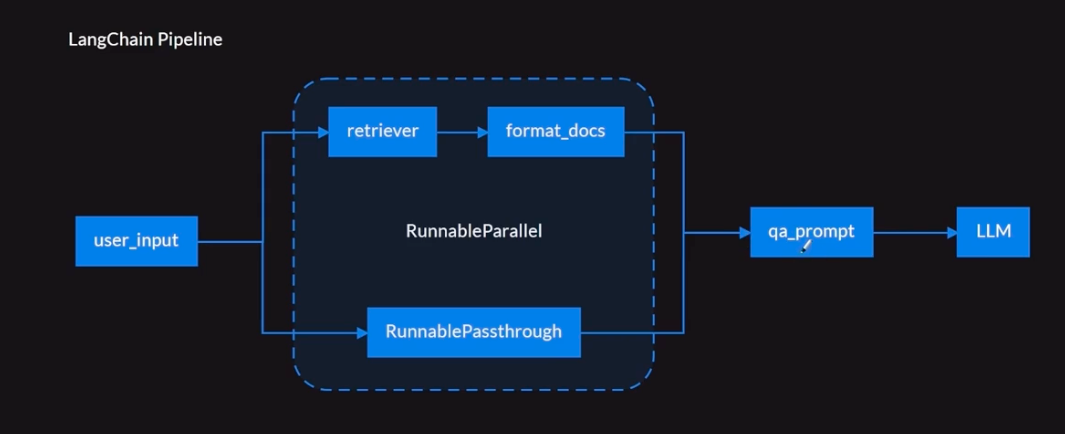

# QA RAG Chain with LCEL implementation

## Install dependencies

In [1]:
!pip install langchain==0.2.0
!pip install langchain-openai==0.1.7
!pip install langchain-community==0.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 372.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.7/973.7 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.9/393.9 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.1/149.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.9/362.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

## Install Chroma Vector DB and LangChain Wrapper

In [2]:
!pip install langchain-chroma

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 559.5/559.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 8.5 MB/s eta 0:00:0

## Enter Open AI API key

In [3]:
from getpass import getpass

OPENAI_KEY = getpass('Enter Open AI API Key: ')

Enter Open AI API Key: ··········


## Setup environment

In [4]:
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY

## Open AI Embedding Models

In [5]:
## get openai embeddings
from langchain_openai import OpenAIEmbeddings

# setup embeddings
openai_embed_model = OpenAIEmbeddings(model='text-embedding-3-small')

## Create Vector Database
* We will use ChromaDB
* We can init connection to Chroma vector DB client and save to disk and initialize the Chroma client and pass directory to where we want it to be saved.

In [9]:
## demo -- sample docs
docs = [
    'Central Vermont is home to the Green Mountain National Forest, which welcomes visitors for leaf-peeping during fall foliage ; snow sports; photography, hiking, camping, and more.',
    'Southern Vermont has it all: ski resorts, shopping, beautiful village greens, cozy inns, fall foliage, and a scattering of historic covered bridges. Ski areas -- Stratton, Bromley, Magic Mountain, and Mount Snow -- offer winter activities and many have warm-weather fun for kids and families. ',
    'Northern Vermont presents contrasts: in the northwest corner is Lake Champlain and Burlington, a cosmopolitan university city of dynamic cultural attractions. Opposite is the Northeast Kingdom, a forested area of proud small towns, outdoor sports and natural grandeur. Jay Peak, has a fabulous ski area an indoor water park. Stowe is a 200-year-old village near Mount Mansfield, Vermonts highest peak. Stowe has an elegant character reminiscent of European mountain resorts, with celebrations all year and family-friendly deals. ',
    'Vermont is a place, but also a state of mind that revels in outdoor beauty, good food, and the preservation of unique small towns and cities. Visitors love Vermont for its colorful fall foliage; ski resorts including Killington, Smugglers Notch, Ascutney, Stowe, and Mount Snow; mountain vistas; and attractions for families and kids. Although Vermont is an inland state, there are wonderful beaches along Lake Champlain, along with many lakes, streams, and swimming holes.',
    'The term Northeast Kingdom was a distinction first mentioned by former Governor George Aiken in the late 1940s to refer to the natural majestic beauty of the area, which follows the northern reaches of the Connecticut River alongside New Hampshire from St. Johnsbury, VT to the Canadian border, then east to the eastern edge of the Green Mountains at Jay Peak. Sometimes abbreviated to the NEK (en-ee-kay), the Northeast Kingdom is made up of over 2,000 square miles of the most untouched and beautifully scenic land in the United States. There are lovely towns to explore in each part of the NEK. In the Eastern Trek: St. Johnsbury, Lyndon, Burke, and Island Pond, which is also known as the snowmobile capital of Vermont. ',
    'Vermont’s land area is 9,216 square miles and more than 70% is forested.',
    'Vermont is home to the highest concentration of sugar maple trees in the U.S., responsible for creating deep fiery reds and oranges of fall foliage.',
    'Lake Champlain covers 435 square miles, offering 212 miles of shoreline in Vermont.',
    'Vermont has 808 lakes and ponds and more than 7,000 miles of rivers and streams.'
    'Vermont has five mountains with peaks higher than 4,000 feet in elevation. Vermont’s highest peak is Mount Mansfield at 4,393 feet.',
    'Vermont is home to 2,100 moose, 4,500-6,000 black bears and 45-50,000 turkeys.',
    'Vermont is home to more than 800,000 acres of land open for hunting. More bucks are harvested per square mile in Vermont than in any other New England state.'
    'Vermont’s waters are home to more than 20 popular species of fish.'
    'Vermont is home to the world’s largest “deep hole” dimension granite quarry and North America’s first marble quarry.'

]

In [10]:
## import chroma
from langchain_chroma import Chroma

# create vector database of docs and embeddings
chroma_db = Chroma.from_texts(texts=docs, collection_name='db_docs',
                              # need to set distance function to cosine otherwise defaults to euclidean
                              collection_metadata={'hnsw:space' : 'cosine'},
                              embedding=openai_embed_model
                              )

## Setup Vector Database Retriever
* We need a retrieval "strategy". We will use **Similarity with Threshold Retrieval**.

### Similarity with Threshold Retrieval
* We use cosine similarity here and retrieve the top 3 similar docs based on user input query and also introduce a cutoff to not return any docs which are below a certain similarity threshold.
* We will use 0.3 or 30% as threshold, anything less is not retrieved.

In [11]:
## setup retriever
similarity_threshold_retriever = chroma_db.as_retriever(search_type='similarity_score_threshold',
                                                        search_kwargs={'k':3,
                                                                       'score_threshold': 0.3}) ## anything less than 30% not returned!

In [13]:
## query 1
query = 'What is the capital of Vermont?'
top3_docs = similarity_threshold_retriever.invoke(query)
top3_docs

[Document(page_content='Northern Vermont presents contrasts: in the northwest corner is Lake Champlain and Burlington, a cosmopolitan university city of dynamic cultural attractions. Opposite is the Northeast Kingdom, a forested area of proud small towns, outdoor sports and natural grandeur. Jay Peak, has a fabulous ski area an indoor water park. Stowe is a 200-year-old village near Mount Mansfield, Vermonts highest peak. Stowe has an elegant character reminiscent of European mountain resorts, with celebrations all year and family-friendly deals. '),
 Document(page_content='Northern Vermont presents contrasts: in the northwest corner is Lake Champlain and Burlington, a cosmopolitan university city of dynamic cultural attractions. Opposite is the Northeast Kingdom, a forested area of proud small towns, outdoor sports and natural grandeur. Jay Peak, has a fabulous ski area an indoor water park. Stowe is a 200-year-old village near Mount Mansfield, Vermonts highest peak. Stowe has an eleg

In [16]:
## query 2
query = 'What mountains are in Vermont?'
top3_docs = similarity_threshold_retriever.invoke(query)
top3_docs

[Document(page_content='Northern Vermont presents contrasts: in the northwest corner is Lake Champlain and Burlington, a cosmopolitan university city of dynamic cultural attractions. Opposite is the Northeast Kingdom, a forested area of proud small towns, outdoor sports and natural grandeur. Jay Peak, has a fabulous ski area an indoor water park. Stowe is a 200-year-old village near Mount Mansfield, Vermonts highest peak. Stowe has an elegant character reminiscent of European mountain resorts, with celebrations all year and family-friendly deals. '),
 Document(page_content='Northern Vermont presents contrasts: in the northwest corner is Lake Champlain and Burlington, a cosmopolitan university city of dynamic cultural attractions. Opposite is the Northeast Kingdom, a forested area of proud small towns, outdoor sports and natural grandeur. Jay Peak, has a fabulous ski area an indoor water park. Stowe is a 200-year-old village near Mount Mansfield, Vermonts highest peak. Stowe has an eleg

# Build a QA RAG Chain
* We need a prompt template which instructs the LLM to not answer questions beyond the scope of the retrieval context documents.
* There are prompts and guardrails out there but we will build a custom one here.

In [17]:
from langchain_core.prompts import ChatPromptTemplate

# prompt
prompt = """You are a skilled assistant for question-answering tasks.
            Use the following pieces of retrieved context to answer the question.
            If no context is present or if you don't know the answer, just say that you don't know.
            Do not make up the answer unless it is there in the provided context.
            Keep the answer concise and to the point with regard to the question.

            Question:
            {question}

            Context:
            {context}

            Answer:
            """

prompt_template = ChatPromptTemplate.from_template(prompt)

## LLM connection

In [18]:
from langchain_openai import ChatOpenAI

## connect to LLM
chatgpt = ChatOpenAI(model_name='gpt-3.5-turbo', temperature=0)

## Legacy LangChain Syntax for QA RAG Chain
* This chain does not use LCEL syntax.

In [19]:
from langchain.chains import RetrievalQA

In [21]:
## build chain
qa_rag_chain = RetrievalQA.from_chain_type(llm=chatgpt,
                                           chain_type='stuff',
                                           retriever=similarity_threshold_retriever,
                                           chain_type_kwargs={'prompt': prompt_template})

In [22]:
query = "What is the capital of Vermont?"
qa_rag_chain.invoke(query)

{'query': 'What is the capital of Vermont?',
 'result': 'The capital of Vermont is Montpelier.'}

In [23]:
query = "Tell me about Montpelier in detail."
qa_rag_chain.invoke(query)

{'query': 'Tell me about Montpelier in detail.',
 'result': 'Montpelier is the capital city of Vermont, known for its small-town charm, historic architecture, and outdoor beauty. It is located in northern Vermont, surrounded by natural grandeur and outdoor sports opportunities.'}

In [25]:
query = 'Tell me about the largest lake in Vermont.'
qa_rag_chain.invoke(query)

{'query': 'Tell me about the largest lake in Vermont.',
 'result': 'The largest lake in Vermont is Lake Champlain, covering 435 square miles with 212 miles of shoreline in the state.'}

Now we can ask a random question not in the database of documents.

In [29]:
query = "Where is the great salt lake?"
qa_rag_chain.invoke(query)

/usr/local/lib/python3.10/dist-packages/langchain_core/vectorstores/base.py:571: UserWarning: No relevant docs were retrieved using the relevance score threshold 0.3
  warnings.warn(


{'query': 'Where is the great salt lake?', 'result': "I don't know."}

## LCEL Syntax for QA RAG Chain - Recommended
* This is how to create a chain using LCEL.

In [30]:
from langchain_core.runnables import RunnablePassthrough

def format_docs(docs):
  return "\n\n".join(doc.page_content for doc in docs)


qa_rag_chain = (
    {
        "context": (similarity_threshold_retriever
                      |
                    format_docs),
        "question": RunnablePassthrough()
    }
     |
    prompt_template
     |
    chatgpt
)


In [31]:
query = "What is the capital of Vermont?"
result = qa_rag_chain.invoke(query)
print(result.content)

The capital of Vermont is Montpelier.


In [32]:
query = "What is the tallest mountain in Vermont?"
result = qa_rag_chain.invoke(query)
print(result.content)

Mount Mansfield at 4,393 feet is the tallest mountain in Vermont.


In [34]:
query = "Where is the great salt lake?"
resutl = qa_rag_chain.invoke(query)
print(result.content)

/usr/local/lib/python3.10/dist-packages/langchain_core/vectorstores/base.py:571: UserWarning: No relevant docs were retrieved using the relevance score threshold 0.3
  warnings.warn(


Mount Mansfield at 4,393 feet is the tallest mountain in Vermont.


Summary:
* We can see that the model hallucinated because it could not find the answer in the vector db.
* This also shows why hand-built guardrails are not perfect and why monitoring LLM outputs are important.